## Initial Data Analysis and Preprocessing
<h4>Team TwinAI</h4>
<h4><b>Overview</b></h4>

This is the IDA and Preprocessing component of our solution to the FormulaAI Hack 2022 Competition. The workflow for this notebook is outlined as follows: 
- Getting the Data
- First Insights: Making Sense of the Data
- Data Integrity Assessment
- Cleaning the Data


In [1]:
import os

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100)


import matplotlib.pyplot as plt
from matplotlib import figure
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('Blues_r')

import deepchecks as dc
from deepchecks.checks.integrity.is_single_value import IsSingleValue
from deepchecks.checks.integrity.data_duplicates import DataDuplicates
from deepchecks.checks import DataDuplicates
from deepchecks.checks.integrity import LabelAmbiguity
from deepchecks.base import Dataset, Suite

from sklearn.preprocessing import StandardScaler
from scipy import stats

import random
import time
from datetime import datetime

import warnings
# warnings.filterwarnings('ignore')


In [2]:
# Reading the CSV file.
data = pd.read_csv('weather.csv',low_memory=False)

<br>
<h4><b>1. First Insights: Making Sense of the Data </b></h4>

In [ ]:
data.shape

In [ ]:
data.info() #check the overall information about the dataset

In [ ]:
data.head(2)

<br>In this dataframe, we see that the last column is an unnamed column. Before we drop it, let us inspect the proportion of NaN values it contains.<br>

In [3]:
print('Missing values:',data['Unnamed: 58'].isnull().sum())
print('Proportion of missing values: {}%'.format(data['Unnamed: 58'].isnull().sum()/data.shape[0]*100))

Missing values: 3572328
Proportion of missing values: 100.0%


Clearly, the unnamed column is entirely filled with missing values and, as such, has no impact in our workflow. It's presence in the data is most likely due to encoding, considering the file format of the data was originally JSON. Thus, the first treatment to our data is to drop this column.

In [4]:
data.drop('Unnamed: 58', axis = 1, inplace = True)
data.shape[1]

58

Now, let's obtain summary statistics for our data 

In [ ]:
data.describe()

<br><b>At a glance:</b>
- A quick inspection of the count row shows us that a number of columns contain missing values, ranging from small to large.
- A quick inspection of the standard deviation shows us that some columns have zero variance, indicating that <b>each of these columns contain ONLY ONE distinct value</b>. Typically, variables whose standard deviations tend to zero have fewer distinct values.
- A quick inspection of the min and max shows us that the very columns having 0 standard deviation <b>contain equal values of minimum and maximum</b>, validating our claim that these columns have only one distinct value.

In this project, we will carry out exhaustive analysis of the data to address the implictations of the forgoing discoveries.</b>


<h4><b>2. Data Integrity Assessment</b></h4>
<p>In this section, we will investigate the integrity of the data and uncover any data quality issues that may be present. The insights we obtain in this section will guide us on how to resolve these issues pragmatically in the next section.</p>

<p><b>(a) Unique Values</b></p>

Our ultimate goal is to build <b>a model that learns the evolution of weather conditions over time</b>. Therefore, we are interested in columns that show variation of values over time. Columns that contain only one unique value <b>may not provide predictive power for the model</b>. We will validate this assumption when we implement feature contribution checks during our model methodology.
<p> First, we make a general inspection of the number of unique values contained in all the columns.</p>

In [ ]:
data.nunique(axis=0).sort_values().to_frame() #check for unique values and sort them into frames

From the above result, we can see that there are 7 columns that contain only one unique value. Below, we obtain further information about what these exact values are.

In [ ]:
sv = IsSingleValue()
sv.run(data)

<br>
<p><b>(b) Data Duplicates<b></p>
We need to run a duplicate check to find if there are multiple instances of identical samples in our dataset. One reason is that duplicates could be an indicator for a problem in the data pipeline that requires attention. The other is that they can potentially increase the weight that a machine learning model gives to samples. 

In [ ]:
print('Proportion of duplicates: {}%'.format(len(data[data.duplicated()])/data.shape[0]*100))
data[data.duplicated()] #check for average duplicate values in the dataset

Now, this is only partially informative. We only know that 2057230 samples, representing ~57% of the data, are duplicated. But this doesn't tell us the number of times each example of duplicate data appears. We will obtain the desired information by implementing the following additional checks.

In [ ]:
#from deepchecks.checks import DataDuplicates
DataDuplicates().run(data)

We can summarise this check by defining a check condition that sets the baseline of duplicate ratio as 0. This will expose any violation to the condition and reveal the present duplicate ratio.

In [ ]:
check = DataDuplicates()
check.add_condition_ratio_not_greater_than(0)
result = check.run(data)
result.show(show_additional_outputs=False)

We are interested in knowing whether the duplicates observed here were intentionally intended to be part of the data. However, if this is an hidden issue we’re not expecting to occur, then we will need to resolve it. We will revisit this in the EDA and Feature Engineering component of our workflow.

<br>
<p><b>(c) Label Ambiguity</b></p>

We would also like to check whether there are identical samples in the data with different labels. This alerts us to further verify whether or not the data was mislabelled, as mislabelled data could confuse the model and lead to lower model performance.

In [ ]:
#from deepchecks.checks.integrity import LabelAmbiguity
#from deepchecks.base import Dataset

In [ ]:
label_ambig = Dataset(data, label='M_WEATHER')
LabelAmbiguity().run(label_ambig)

Again, we summarise this check by defining a check condition that sets the baseline of ambiguous sample ratio as 0. This will expose any violation to the condition and reveal the present ambiguous sample ratio.

In [ ]:
check = LabelAmbiguity()
check.add_condition_ambiguous_sample_ratio_not_greater_than(0)
result = check.run(label_ambig)
result.show(show_additional_outputs=False)

Indeed, we observe that there are no identical samples with different labels.

<br>
<p><b>(d) Missing Values</b></p>

In [203]:
data.isna().sum().sort_values().to_frame() #check for missing values and sort them into frames

,0
M_PACKET_FORMAT,0
M_SLI_PRO_NATIVE_SUPPORT,0
M_SAFETY_CAR_STATUS,0
M_TRACK_ID,0
M_ERSASSIST,0
M_SEASON_LINK_IDENTIFIER,0
M_PIT_ASSIST,0
M_GEARBOX_ASSIST,0
M_SESSION_TYPE,0
M_NUM_WEATHER_FORECAST_SAMPLES,0


In [204]:
data.notna().sum().sort_values().to_frame() #check for non-missing values and sort them into frames

,0
M_ZONE_START,974274
M_ZONE_FLAG,974274
M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,2598054
M_TIME_OFFSET,2598054
M_WEATHER_FORECAST_SAMPLES_M_WEATHER,2598054
M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,2598054
M_TRACK_TEMPERATURE_CHANGE,2598054
M_RAIN_PERCENTAGE,2598054
M_AIR_TEMPERATURE_CHANGE,2598054
M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,2598054


From the above two cells, we immediately note the following:
- There are 18 columns with missing values, out of which 7 have only 1 missing value.
- Of the 18 columns, the number of missing values found in 8 columns (i.e., 974274 each) and the number found in 2 columns (i.e., 2598054) sum up to the length of the dataframe. 

Could there be a complimentary relationship, where columns in one set are filled in rows where those of the other set are missing?
To uncover this, we isolate the columns <b>M_WEATHER_PERCENTAGE and M_ZONE_START</b> and inspect the distribution of the missing vales across them. Due to the length of the dataframe, we slice a fraction of the data and visualise the distribution of missing values.

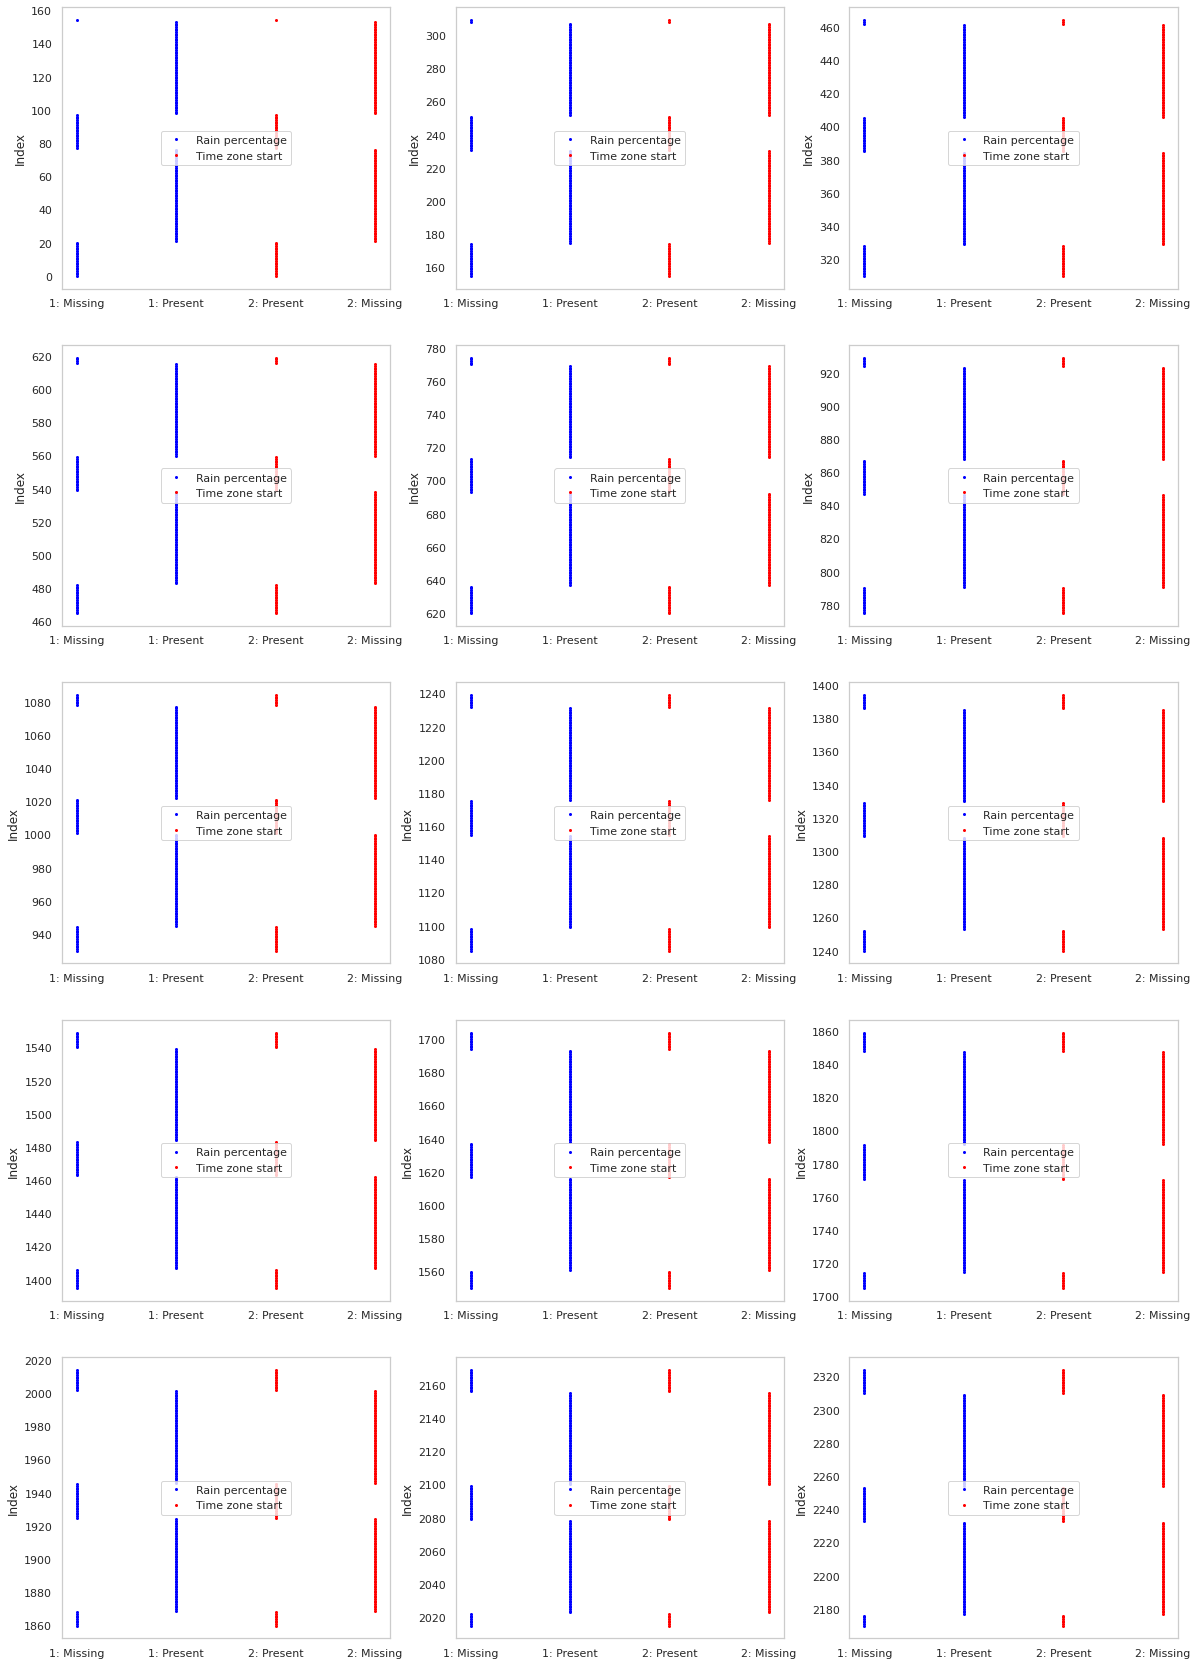

In [206]:
xdf = data.copy()
xdf.M_RAIN_PERCENTAGE = np.where(xdf.M_RAIN_PERCENTAGE.isnull(),'1: Missing','1: Present')
xdf.M_ZONE_START = np.where(xdf.M_ZONE_START.isnull(),'2: Missing','2: Present')
xdf.M_ZONE_START.unique()

plt.figure(figsize=(20,30))
count = 0
for i in range(1,16):
    x1 = xdf[count:count+155].M_RAIN_PERCENTAGE
    x2 = xdf[count:count+155].M_ZONE_START
    index = range(count,count+155)
    plt.subplot(5,3,i)
    plt.plot(x1,index,'bo',markersize = 2,label='Rain percentage')
    plt.plot(x2,index,'ro',markersize = 2,label='Time zone start')
    plt.ylabel('Index') 
    plt.legend(loc='center')
    plt.grid(False)
    count+=155

From these plots, we can generalise that the missing values in one column appear in rows where the others are filled. This holds true for the other columns across the two sets. As the insights build up, we will understand later how to prepare the data to achieve overall completeness and accuracy.

<br>
<h4><b>4. Cleaning the Data</b></h4>

<b> (a) We will drop the following rows immediately </b>
1. Rows where the number of forcast samples equals 0 as they provide no prediction at time t = 0
2. Rows where the session type is unknown (0)
3. Rows where the packet received shows a session type of NaN or 0
4. Rows where the packet received is sent while the game is paused
5. Rows where the packet received shows player is both spectating and playing online (inconsistency)
6. Rows where marshal_zone_start or marshal_zone_flag is null, as these indicates gaps in the game

In [5]:
df = data.copy()
df.shape

(3572328, 58)

In [6]:
df.drop(df[df['M_NUM_WEATHER_FORECAST_SAMPLES']==0].index, inplace=True)
df[df['M_NUM_WEATHER_FORECAST_SAMPLES']==0].count()

M_PACKET_FORMAT                                   0
M_GAME_MAJOR_VERSION                              0
M_GAME_MINOR_VERSION                              0
M_PACKET_VERSION                                  0
M_PACKET_ID                                       0
M_SESSION_UID                                     0
M_SESSION_TIME                                    0
M_FRAME_IDENTIFIER                                0
M_PLAYER_CAR_INDEX                                0
M_SECONDARY_PLAYER_CAR_INDEX                      0
M_BRAKING_ASSIST                                  0
M_SESSION_LINK_IDENTIFIER                         0
M_PIT_RELEASE_ASSIST                              0
TIMESTAMP                                         0
M_ZONE_START                                      0
M_ZONE_FLAG                                       0
M_PIT_STOP_WINDOW_IDEAL_LAP                       0
M_TRACK_TEMPERATURE                               0
M_TRACK_LENGTH                                    0
M_GAME_PAUSE

In [7]:
df.shape

(2745117, 58)

In [8]:
df.drop(df[df['M_SESSION_TYPE']==0].index, inplace=True)
df.shape

(2745117, 58)

In [9]:
df.drop(df[df['M_GAME_PAUSED']==1].index, inplace=True)
df.shape

(2696299, 58)

In [10]:
df.drop(df[(df['M_IS_SPECTATING'] == 1) & (df['M_NETWORK_GAME'] == 1)].index, inplace=True)
df.shape

(2690986, 58)

In [11]:
df.drop(df[df['M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE'].isnull()].index, inplace=True)
df.shape

(1957078, 58)

This last operation leaves the zone start and zone flag columns with NaN values as we can see below. We will therefore eliminate this column in due time.

In [240]:
df['M_ZONE_FLAG'].isnull().sum()

1957078

<br><b>(a) We will drop the following columns immediately:</b>
1. Redundant columns not included with the packet, starting with gamehost and timestamp
2. Redundant columns with single unique values (i.e., predominantly ID columns)
3. Duplicated Columns
4. Already Engineered Columns
5. Forcast samples columns outside weather and %rainfall, since this is a weather forecast project

We start by aggregating the session duration and Session time left column to generate a new column representing the time delta in the data.

In [12]:
df['M_SESSION_TIME_SPENT'] = df['M_SESSION_DURATION'] - df['M_SESSION_TIME_LEFT']

In [13]:
# drop_col = ['GAMEHOST','TIMESTAMP', 'M_ZONE_FLAG', 'M_ZONE_START', 'M_SESSION_DURATION', 
#            'M_SESSION_TIME_LEFT', 'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE', 
#             'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE', 'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE']

drop_col = ['GAMEHOST','TIMESTAMP', 'M_ZONE_FLAG', 'M_ZONE_START', 'M_SESSION_DURATION', 
           'M_SESSION_TIME_LEFT']

for col in df.columns:
    if df[col].nunique()<2:
        drop_col.append(col)
print(drop_col)
len(drop_col)

['GAMEHOST', 'TIMESTAMP', 'M_ZONE_FLAG', 'M_ZONE_START', 'M_SESSION_DURATION', 'M_SESSION_TIME_LEFT', 'M_PACKET_FORMAT', 'M_GAME_MAJOR_VERSION', 'M_GAME_MINOR_VERSION', 'M_PACKET_VERSION', 'M_PACKET_ID', 'M_SECONDARY_PLAYER_CAR_INDEX', 'M_ZONE_START', 'M_ZONE_FLAG', 'M_GAME_PAUSED', 'GAMEHOST', 'M_SLI_PRO_NATIVE_SUPPORT', 'M_SAFETY_CAR_STATUS', 'M_SPECTATOR_CAR_INDEX', 'M_IS_SPECTATING']


20

In [14]:
df.drop(drop_col, axis=1, inplace=True)

In [15]:
df.count()

M_SESSION_UID                                     1957078
M_SESSION_TIME                                    1957078
M_FRAME_IDENTIFIER                                1957078
M_PLAYER_CAR_INDEX                                1957078
M_BRAKING_ASSIST                                  1957078
M_SESSION_LINK_IDENTIFIER                         1957078
M_PIT_RELEASE_ASSIST                              1957078
M_PIT_STOP_WINDOW_IDEAL_LAP                       1957078
M_TRACK_TEMPERATURE                               1957078
M_TRACK_LENGTH                                    1957078
M_FORECAST_ACCURACY                               1957078
M_AIR_TEMPERATURE                                 1957078
M_NUM_WEATHER_FORECAST_SAMPLES                    1957078
M_TRACK_ID                                        1957078
M_ERSASSIST                                       1957078
M_FORMULA                                         1957078
M_SEASON_LINK_IDENTIFIER                          1957078
M_PIT_ASSIST  

In [16]:
df.isna().any().sum()

6

<b>(c) Filling in the 6 columns containing single missing values</b>

In [20]:
fill_col = df.columns[df.isna().any() == True]
for col in fill_col:
    df[col].fillna(df[col].mode()[0], inplace=True)
df.isna().any().sum()

0

In [21]:
#Shape of data before cleaning
data.shape

(3572328, 58)

In [22]:
#Shape of data after cleaning
df.shape

(1957078, 42)

In [ ]:
df.to_csv('cleaned_data.csv', encoding='utf-8', index=False)

In [80]:
de = df.copy()

Notes to copy out

In [25]:
dd = de.groupby(['M_SESSION_UID', 'M_TIME_OFFSET'])
dd.first()

M_GAME_MINOR_VERSION  M_SESSION_TIME  \
M_SESSION_UID        M_TIME_OFFSET                                         
21060822879603068    0.0                              14          28.860   
                     5.0                              14          28.860   
                     10.0                             14          28.860   
                     15.0                             14          28.860   
                     30.0                             14          28.860   
...                                                  ...             ...   
18024707237561859570 10.0                             14           0.004   
                     15.0                             14           0.004   
                     30.0                             14           0.004   
                     45.0                             14           0.004   
                     60.0                             14           0.004   

                                    M_FRAME_IDENTIFIER  M_PLAYER_CAR_INDEX  \
M_SESSION_UID        M_TIME_OFFSET                                           
21060822879603068    0.0                           624                  19   
                     5.0                           624                  19   
                     10.0                          624                  19   
                     15.0                          624                  19   
                     30.0                          624                  19   
...                                                ...                 ...   
18024707237561859570 10.0                            0                   0   
                     15.0                            0                   0   
                     30.0                            0                   0   
                     45.0                            0                   0   
                     60.0                            0                   0   

                                    M_BRAKING_ASSIST  \
M_SESSION_UID        M_TIME_OFFSET                     
21060822879603068    0.0                           0   
                     5.0                           0   
                     10.0                          0   
                     15.0                          0   
                     30.0                          0   
...                                              ...   
18024707237561859570 10.0                          0   
                     15.0                          0   
                     30.0                          0   
                     45.0                          0   
                     60.0                          0   

                                    M_SESSION_LINK_IDENTIFIER  \
M_SESSION_UID        M_TIME_OFFSET                              
21060822879603068    0.0                           2184232491   
                     5.0                           2184232491   
                     10.0                          2184232491   
                     15.0                          2184232491   
                     30.0                          2184232491   
...                                                       ...   
18024707237561859570 10.0                          3846328341   
                     15.0                          3846328341   
                     30.0                          3846328341   
                     45.0                          3846328341   
                     60.0                          3846328341   

                                    M_PIT_RELEASE_ASSIST  \
M_SESSION_UID        M_TIME_OFFSET                         
21060822879603068    0.0                               0   
                     5.0                               0   
                     10.0                              0   
                     15.0                              0   
                     30.0                              0   
...                                  

In [39]:
dd = de.groupby('M_PLAYER_CAR_INDEX')
dd.first()

,M_PACKET_FORMAT,M_GAME_MAJOR_VERSION,M_GAME_MINOR_VERSION,M_PACKET_VERSION,M_PACKET_ID,M_SESSION_UID,M_SESSION_TIME,M_FRAME_IDENTIFIER,M_SECONDARY_PLAYER_CAR_INDEX,M_BRAKING_ASSIST,M_SESSION_LINK_IDENTIFIER,M_PIT_RELEASE_ASSIST,TIMESTAMP,M_ZONE_START,M_ZONE_FLAG,M_PIT_STOP_WINDOW_IDEAL_LAP,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_GAME_PAUSED,M_FORECAST_ACCURACY,GAMEHOST,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_SLI_PRO_NATIVE_SUPPORT,M_SAFETY_CAR_STATUS,M_TRACK_ID,M_ERSASSIST,M_FORMULA,M_SEASON_LINK_IDENTIFIER,M_PIT_ASSIST,M_GEARBOX_ASSIST,M_SESSION_TYPE,M_SPECTATOR_CAR_INDEX,M_PIT_STOP_WINDOW_LATEST_LAP,M_WEEKEND_LINK_IDENTIFIER,M_DYNAMIC_RACING_LINE_TYPE,M_SESSION_TIME_LEFT,M_SESSION_DURATION,M_PIT_STOP_REJOIN_POSITION,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_TIME_OFFSET,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_AI_DIFFICULTY,M_PIT_SPEED_LIMIT,M_NETWORK_GAME,M_TOTAL_LAPS,M_STEERING_ASSIST,M_IS_SPECTATING,M_DYNAMIC_RACING_LINE,M_DRSASSIST,M_NUM_MARSHAL_ZONES
M_PLAYER_CAR_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2021,1,14,1,1,13002103581294142936,2803.836,82458,255,0,0,0,1.642362e+09,0.088,0.0,0,33,4650,0,0,f1digest,25,0,0,0,28,0,0,0,0,1,13,255,0,0,0,0,600,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,80,0.0,200.0,0.0,0.0,0.0,0.0,16.0
1,2021,1,14,1,1,10862815468833217499,294.170,9300,255,0,2756721461,0,1.642288e+09,0.088,0.0,0,33,4650,0,0,f1digest,25,10,0,0,28,0,0,2756721461,0,1,8,255,0,2756721461,0,785,1080,0,8.0,0.0,0.0,33.0,2.0,25.0,2.0,4.0,0,110,80,1.0,200.0,0.0,0.0,0.0,0.0,16.0
2,2021,1,14,1,1,7388521933043485045,689.166,18543,255,2,1484504761,1,1.641594e+09,0.944,0.0,0,28,5815,0,0,None,20,9,0,0,1,1,0,1484504721,1,3,10,255,0,1484504721,1,2626,7200,8,10.0,0.0,1.0,29.0,2.0,21.0,2.0,4.0,1,31,60,0.0,53.0,0.0,0.0,2.0,1.0,17.0
3,2021,1,14,1,1,7876673241077905524,119.939,2419,255,3,4155675888,1,1.641394e+09,0.136,1.0,0,31,4525,0,0,None,23,3,0,0,19,1,0,4155674778,1,3,10,255,0,4155675878,1,7085,7200,13,10.0,0.0,0.0,32.0,2.0,23.0,2.0,2.0,0,41,80,1.0,5.0,1.0,0.0,2.0,1.0,13.0
6,2021,1,14,1,1,2250909318467216152,14.715,285,255,3,4155675778,1,1.641392e+09,0.861,0.0,0,28,4257,0,0,None,19,6,0,0,26,1,0,4155674778,1,3,9,255,0,4155675778,1,0,240,0,9.0,0.0,0.0,28.0,2.0,19.0,2.0,3.0,0,41,80,1.0,200.0,1.0,0.0,2.0,1.0,10.0
8,2021,1,14,1,1,2375253586702444216,224.154,4221,255,3,4155675688,1,1.641392e+09,0.025,0.0,0,34,5798,0,0,None,26,3,0,0,11,1,0,4155674778,1,3,10,255,0,4155675678,1,6981,7200,10,10.0,0.0,0.0,34.0,2.0,27.0,2.0,2.0,0,41,80,1.0,5.0,1.0,0.0,2.0,1.0,17.0
18,2021,1,14,1,1,10924589045696636837,47.570,902,255,3,2763502775,1,1.641407e+09,0.000,0.0,0,33,4910,0,1,None,25,3,0,0,27,1,3,2763502765,1,3,10,255,0,2763502765,1,7158,7200,12,10.0,0.0,0.0,33.0,2.0,25.0,2.0,4.0,0,41,80,1.0,5.0,0.0,0.0,2.0,1.0,18.0
19,2021,1,14,1,1,3734445177271223582,1402.855,28562,255,0,3081081018,1,1.641829e+09,0.954,0.0,0,36,5408,0,1,f1digest,29,48,0,0,3,1,0,3081081018,1,3,1,255,0,3081081018,1,3068,3600,0,1.0,0.0,0.0,36.0,2.0,29.0,2.0,2.0,0,31,80,0.0,200.0,0.0,0.0,2.0,1.0,17.0


In [40]:
de['M_PLAYER_CAR_INDEX'].nunique()

8

In [34]:
df.groupby(['M_SESSION_TYPE','M_TIME_OFFSET']).first()

M_PACKET_FORMAT  M_GAME_MAJOR_VERSION  \
M_SESSION_TYPE M_TIME_OFFSET                                          
1              0.0                       2021                     1   
               5.0                       2021                     1   
               10.0                      2021                     1   
               15.0                      2021                     1   
               30.0                      2021                     1   
               45.0                      2021                     1   
               60.0                      2021                     1   
               90.0                      2021                     1   
               120.0                     2021                     1   
5              0.0                       2021                     1   
               5.0                       2021                     1   
               10.0                      2021                     1   
               15.0                      2021                     1   
               30.0                      2021                     1   
               45.0                      2021                     1   
               60.0                      2021                     1   
               90.0                      2021                     1   
               120.0                     2021                     1   
8              0.0                       2021                     1   
               5.0                       2021                     1   
               10.0                      2021                     1   
               15.0                      2021                     1   
               30.0                      2021                     1   
               45.0                      2021                     1   
               60.0                      2021                     1   
9              0.0                       2021                     1   
               5.0                       2021                     1   
               10.0                      2021                     1   
10             0.0                       2021                     1   
               5.0                       2021                     1   
               10.0                      2021                     1   
               15.0                      2021                     1   
               30.0                      2021                     1   
               45.0                      2021                     1   
               60.0                      2021                     1   
               90.0                      2021                     1   
               120.0                     2021                     1   
13             0.0                       2021                     1   

                              M_GAME_MINOR_VERSION  M_PACKET_VERSION  \
M_SESSION_TYPE M_TIME_OFFSET                                           
1              0.0                              14                 1   
               5.0                              14                 1   
               10.0                             14                 1   
               15.0                             14                 1   
               30.0                             14                 1   
               45.0                             14                 1   
               60.0                             14                 1   
               90.0                             14                 1   
               120.0                            14                 1   
5              0.0                              14                 1   
               5.0                              14                 1   
               10.0                             14                 1   
               15.0                             14                 1   
               30.0                             14                 1   
               45.0                  

In [35]:
df['M_SESSION_TYPE'].nunique()

6

In [23]:
df[['M_NUM_WEATHER_FORECAST_SAMPLES','M_TIME_OFFSET']]

,M_NUM_WEATHER_FORECAST_SAMPLES,M_TIME_OFFSET
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN
...,...,...
3572323,10,0.0
3572324,10,0.0
3572325,10,0.0
3572326,10,0.0


In [ ]:
da = pd.DataFrame(df.groupby(['M_PACKET_ID', 'M_TIME_OFFSET']))

In [9]:
da.shape

AttributeError: 'DataFrameGroupBy' object has no attribute 'shape'

In [25]:
dd.first().columns

Index(['M_GAME_MINOR_VERSION', 'M_SESSION_TIME', 'M_FRAME_IDENTIFIER',
       'M_PLAYER_CAR_INDEX', 'M_BRAKING_ASSIST', 'M_SESSION_LINK_IDENTIFIER',
       'M_PIT_RELEASE_ASSIST', 'M_PIT_STOP_WINDOW_IDEAL_LAP',
       'M_TRACK_TEMPERATURE', 'M_TRACK_LENGTH', 'M_GAME_PAUSED',
       'M_FORECAST_ACCURACY', 'M_AIR_TEMPERATURE',
       'M_NUM_WEATHER_FORECAST_SAMPLES', 'M_TRACK_ID', 'M_ERSASSIST',
       'M_FORMULA', 'M_SEASON_LINK_IDENTIFIER', 'M_PIT_ASSIST',
       'M_GEARBOX_ASSIST', 'M_SESSION_TYPE', 'M_SPECTATOR_CAR_INDEX',
       'M_PIT_STOP_WINDOW_LATEST_LAP', 'M_WEEKEND_LINK_IDENTIFIER',
       'M_DYNAMIC_RACING_LINE_TYPE', 'M_SESSION_TIME_LEFT',
       'M_SESSION_DURATION', 'M_PIT_STOP_REJOIN_POSITION',
       'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
       'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
       'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
       'M_TRACK_TEMPERATURE_CHANGE',
       'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE',
       'M_AIR_TEMPERATURE_CHANGE',

Clearly, we can see that the time offset and the forecast prediction changes for each session.
Now, let's see what features are aligned to this changes so we note them in the feature selection phase for our model.

In [26]:
dl = de.groupby('M_SESSION_UID')
dh = dl.get_group(21060822879603068)
di = dl.get_group(18024707237561859570)
#dh.nunique().to_frame()

In [27]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import GenericUnivariateSelect

In [28]:
dff1 = dh.copy()
target1 = dff1['M_WEATHER']
target2 = dff1['M_RAIN_PERCENTAGE']
features = dff1.drop(['M_WEATHER','M_RAIN_PERCENTAGE'],axis=1)
features.shape

(7546, 45)

In [29]:
dff2 = di.copy()
target_1 = dff2['M_WEATHER']
target_2 = dff2['M_RAIN_PERCENTAGE']
features2 = dff2.drop(['M_WEATHER','M_RAIN_PERCENTAGE'],axis=1)
features2.shape

(308, 45)

In [30]:
trans = GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0), mode='percentile', param=50)
features_trans = trans.fit_transform(features, target1)

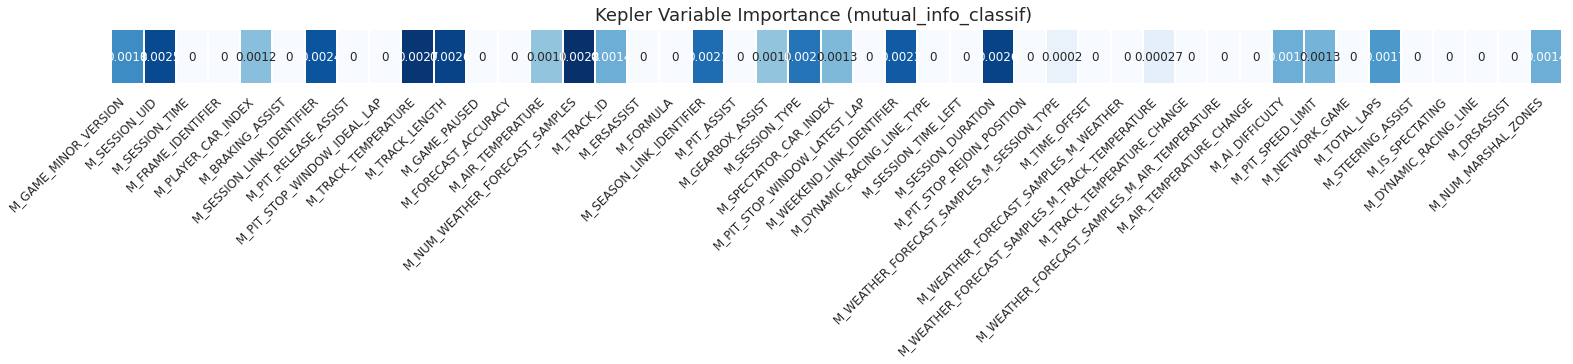

In [31]:
kepler_mutual_information = mutual_info_classif(features, target1)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(features.columns[0:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

In [31]:
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode = 'percentile', param=50)
kepler_X_trans = trans.fit_transform(features, target1)

In [33]:
columns_retained_Select = features.iloc[:, :].columns[trans.get_support()].values
features_selected_1 = pd.DataFrame(kepler_X_trans, columns=columns_retained_Select)
features_selected_1.head()

,M_GAME_MINOR_VERSION,M_SESSION_UID,M_PLAYER_CAR_INDEX,M_SESSION_LINK_IDENTIFIER,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_TRACK_ID,M_SEASON_LINK_IDENTIFIER,M_GEARBOX_ASSIST,M_SESSION_TYPE,M_SPECTATOR_CAR_INDEX,M_WEEKEND_LINK_IDENTIFIER,M_SESSION_DURATION,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_AI_DIFFICULTY,M_PIT_SPEED_LIMIT,M_TOTAL_LAPS,M_NUM_MARSHAL_ZONES
0,14.0,2.106082e+16,19.0,2.184232e+09,33.0,4650.0,25.0,10.0,28.0,2.184232e+09,1.0,8.0,255.0,2.184232e+09,1080.0,0.0,0.0,0.0,90.0,80.0,200.0,16.0
1,14.0,2.106082e+16,19.0,2.184232e+09,33.0,4650.0,25.0,10.0,28.0,2.184232e+09,1.0,8.0,255.0,2.184232e+09,1080.0,0.0,0.0,0.0,90.0,80.0,200.0,16.0
2,14.0,2.106082e+16,19.0,2.184232e+09,33.0,4650.0,25.0,10.0,28.0,2.184232e+09,1.0,8.0,255.0,2.184232e+09,1080.0,0.0,0.0,0.0,90.0,80.0,200.0,16.0
3,14.0,2.106082e+16,19.0,2.184232e+09,33.0,4650.0,25.0,10.0,28.0,2.184232e+09,1.0,8.0,255.0,2.184232e+09,1080.0,0.0,0.0,0.0,90.0,80.0,200.0,16.0
4,14.0,2.106082e+16,19.0,2.184232e+09,33.0,4650.0,25.0,10.0,28.0,2.184232e+09,1.0,8.0,255.0,2.184232e+09,1080.0,0.0,0.0,0.0,90.0,80.0,200.0,16.0


In [34]:
features_selected_1.shape

(7546, 22)

In [35]:
_fs_output_column = features_selected_1.columns.tolist()

In [36]:
_fs_output_column.extend(['M_WEATHER','M_RAIN_PERCENTAGE','M_TIME_OFFSET'])

In [37]:
_fs_output_column

['M_GAME_MINOR_VERSION',
 'M_SESSION_UID',
 'M_PLAYER_CAR_INDEX',
 'M_SESSION_LINK_IDENTIFIER',
 'M_TRACK_TEMPERATURE',
 'M_TRACK_LENGTH',
 'M_AIR_TEMPERATURE',
 'M_NUM_WEATHER_FORECAST_SAMPLES',
 'M_TRACK_ID',
 'M_SEASON_LINK_IDENTIFIER',
 'M_GEARBOX_ASSIST',
 'M_SESSION_TYPE',
 'M_SPECTATOR_CAR_INDEX',
 'M_WEEKEND_LINK_IDENTIFIER',
 'M_SESSION_DURATION',
 'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
 'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
 'M_TRACK_TEMPERATURE_CHANGE',
 'M_AI_DIFFICULTY',
 'M_PIT_SPEED_LIMIT',
 'M_TOTAL_LAPS',
 'M_NUM_MARSHAL_ZONES',
 'M_WEATHER',
 'M_RAIN_PERCENTAGE',
 'M_TIME_OFFSET']

In [39]:
final_data = de[_fs_output_column]
final_data.head()

,M_GAME_MINOR_VERSION,M_SESSION_UID,M_PLAYER_CAR_INDEX,M_SESSION_LINK_IDENTIFIER,M_TRACK_TEMPERATURE,M_TRACK_LENGTH,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_TRACK_ID,M_SEASON_LINK_IDENTIFIER,M_GEARBOX_ASSIST,M_SESSION_TYPE,M_SPECTATOR_CAR_INDEX,M_WEEKEND_LINK_IDENTIFIER,M_SESSION_DURATION,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_AI_DIFFICULTY,M_PIT_SPEED_LIMIT,M_TOTAL_LAPS,M_NUM_MARSHAL_ZONES,M_WEATHER,M_RAIN_PERCENTAGE,M_TIME_OFFSET
17017,14,2939734289500381614,0,1553478724,33,4650,25,10,28,1553478724,1,8,255,1553478724,1080,0.0,0.0,0.0,31,80,200.0,16.0,0,0.0,0.0
17018,14,2939734289500381614,0,1553478724,33,4650,25,10,28,1553478724,1,8,255,1553478724,1080,0.0,0.0,0.0,31,80,200.0,16.0,0,0.0,0.0
17019,14,2939734289500381614,0,1553478724,33,4650,25,10,28,1553478724,1,8,255,1553478724,1080,0.0,0.0,0.0,31,80,200.0,16.0,0,0.0,0.0
17020,14,2939734289500381614,0,1553478724,33,4650,25,10,28,1553478724,1,8,255,1553478724,1080,0.0,0.0,0.0,31,80,200.0,16.0,0,0.0,0.0
17021,14,2939734289500381614,0,1553478724,33,4650,25,10,28,1553478724,1,8,255,1553478724,1080,0.0,0.0,0.0,31,80,200.0,16.0,0,0.0,0.0


In [40]:
final_data.shape

(2745117, 25)

In [41]:
final_data.isna().sum()

M_GAME_MINOR_VERSION                              0
M_SESSION_UID                                     0
M_PLAYER_CAR_INDEX                                0
M_SESSION_LINK_IDENTIFIER                         0
M_TRACK_TEMPERATURE                               0
M_TRACK_LENGTH                                    0
M_AIR_TEMPERATURE                                 0
M_NUM_WEATHER_FORECAST_SAMPLES                    0
M_TRACK_ID                                        0
M_SEASON_LINK_IDENTIFIER                          0
M_GEARBOX_ASSIST                                  0
M_SESSION_TYPE                                    0
M_SPECTATOR_CAR_INDEX                             0
M_WEEKEND_LINK_IDENTIFIER                         0
M_SESSION_DURATION                                0
M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE         0
M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE    0
M_TRACK_TEMPERATURE_CHANGE                        0
M_AI_DIFFICULTY                                   0
M_PIT_SPEED_

In [42]:
final_data.to_csv('final_data.csv', index=False)

KeyError: 0

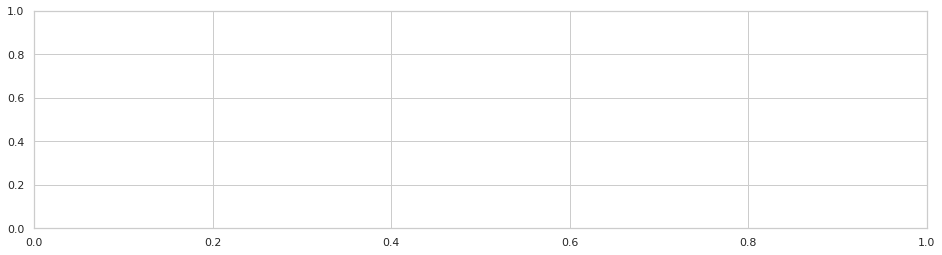

In [62]:
#X_train = de.copy()
#X_train.drop('M_WEATHER')
#y_train = de.M_WEATHER

fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in df.M_WEATHER.unique():
    X_train[].loc[y_train == label, "M_RAIN_PERCENTAGE"][0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

In [11]:
df.M_WEATHER.unique()

array([0, 5, 1, 2])

In [57]:
X_train.loc[y_train == label, "M_RAIN_PERCENTAGE"]

17017      0.0
17018      0.0
17019      0.0
17020      0.0
17021      0.0
          ... 
3572323    0.0
3572324    0.0
3572325    0.0
3572326    0.0
3572327    0.0
Name: M_RAIN_PERCENTAGE, Length: 1880022, dtype: float64